In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#pip install wandb

Create a siamese network for immage classification

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


In [4]:

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

load data

In [5]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('/content/drive/MyDrive/Colab Notebooks/efficent net/data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [6]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])


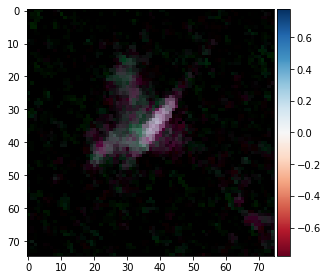

This is: Iceberg


In [7]:
plot_image(101)

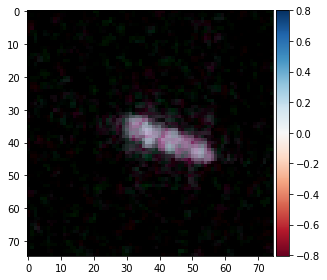

This is: Ship


In [8]:
plot_image(100)

create a base network

In [27]:
# Koch et al.   
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(),
            nn.Flatten(),

            
        )
        self.out = nn.Linear(18,1)
        
        
        #self.dropout=nn.Dropout(p=0.5) 
        
        self.fc1=nn.Sequential(
            nn.Flatten(),
            nn.Linear(2268,18),
            nn.Sigmoid())
        
        #self.out=nn.Sequential(
            #nn.Linear(512, 1),
            #nn.Sigmoid())

        
        
        
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.2)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        #inp=inp.view(inp.size()[0], -1)
        #inp = self.dropout(inp) #
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [11]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

In [12]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) # 0.25 x 0.8 = 0.2

In [13]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [14]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomGrayscale(0.5),
    )

Train data

In [15]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)

In [16]:

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset.targets[num_img])])


Validation data

In [17]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

Test data

In [18]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

In [19]:
num_workers = 2
bs = 16
# Rest of the code goes the same

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)


validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [20]:
del X_train,Y_train,train_dataset,validation_dataset,image_list_train,image_list_val

train model

In [28]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 2.5e-4 )#, weight_decay = 2.5e-4 
lambda2 = lambda epoch: 0.99
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)

train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [22]:
wandb.init(
      # Set the project where this run will be logged
      project="siamese_net", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      #name=f"experiment_{epoch}", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.01,
      "architecture": "Siamese Network",
      "dataset": "Iceberg",
      "epochs": 10,
      })

wandb: Currently logged in as: thomas-borsani1. Use `wandb login --relogin` to force relogin


In [34]:
n_epochs = 20
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
counter = []
loss_history = [] 
iteration_number= 0
valid_loss_min = np.Inf 
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    sum_train_loss = 0.0
    sum_valid_loss = 0.0
    train_epoch_loss=0.0
    valid_epoch_loss = 0.0
    correct = 0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()*label.size(0)
        # Compute accuracy and accumulate
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()

        bar.set_postfix(ordered_dict={"train_loss": train_epoch_loss})
    
  
    iteration_number += 1
    counter.append(iteration_number)
    loss_history.append(train_epoch_loss)
    train_metrics = {"train/train_loss": train_epoch_loss/ len(train_dataset_loader), 
                       "train/train_accuracy": correct / len(train_dataset_loader)}

    ######################    
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    count = 0
    correct = 0
    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            valid_epoch_loss += loss.item()*label.size(0)
            # Compute accuracy and accumulate
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()

            count += 1
            bar.set_postfix(ordered_dict={"valid_loss":loss.item()})
    
    val_metrics = {"val/val_loss": valid_epoch_loss/ len(validation_dataset_loader), 
                       "val/val_accuracy": correct / len(validation_dataset_loader)}
    wandb.log({**train_metrics, **val_metrics})
    

    train_loss_list.append(train_epoch_loss)
    valid_loss_list.append(valid_epoch_loss)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    print("Average training loss after {} epochs : {}".format(epoch, train_epoch_loss/len(train_dataset_loader)))
    print("Average validation loss after {} epochs : {}".format(epoch, valid_epoch_loss/len(validation_dataset_loader)))


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 1 epochs : 11.081170713052297
Average validation loss after 1 epochs : 11.063736464104895


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Average training loss after 2 epochs : 10.535433460962828
Average validation loss after 2 epochs : 8.822856080835884


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 3 epochs : 8.908657385527473
Average validation loss after 3 epochs : 7.316939687754199


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 4 epochs : 8.218165708771417
Average validation loss after 4 epochs : 7.120243052798278


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 5 epochs : 7.767704406687549
Average validation loss after 5 epochs : 6.628031756864517


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 6 epochs : 7.520717938814226
Average validation loss after 6 epochs : 6.449862715652556


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 7 epochs : 7.298911876680005
Average validation loss after 7 epochs : 6.239482043573217


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 8 epochs : 7.1546105221015734
Average validation loss after 8 epochs : 6.189618429304688


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30><function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a c

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 9 epochs : 7.001996601892144
Average validation loss after 9 epochs : 6.07154872013907


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 10 epochs : 6.76510331566295
Average validation loss after 10 epochs : 6.052164384941525


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 11 epochs : 6.71117642882392
Average validation loss after 11 epochs : 5.8643023033120025


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 12 epochs : 6.61528158720972
Average validation loss after 12 epochs : 5.941967890335663


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 13 epochs : 6.508815505370986
Average validation loss after 13 epochs : 5.911776462194591


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 14 epochs : 6.397731294402828
Average validation loss after 14 epochs : 6.088455832938583


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 15 epochs : 6.319801286845734
Average validation loss after 15 epochs : 5.953029867155405


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 16 epochs : 6.05796709132323
Average validation loss after 16 epochs : 5.7003832854719345


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 17 epochs : 6.075517641343086
Average validation loss after 17 epochs : 5.503907614071103


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 18 epochs : 5.893373846980593
Average validation loss after 18 epochs : 5.326874140523446


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 19 epochs : 5.891302250114633
Average validation loss after 19 epochs : 5.625586351036158


  0%|          | 0/823 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/206 [00:00<?, ?it/s, valid_loss=0]

Average training loss after 20 epochs : 5.741271137182951
Average validation loss after 20 epochs : 5.542072498883817


Evaluate on test set

In [35]:
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64,shuffle=False, num_workers=2)


In [36]:
result = []

with torch.no_grad():
    net.eval()
    correct=0
    count=0
    correct_count=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        

        # check if prediction and actual label are same
        for j in range(output.size(0)):

            if (output[j]>0.5) and (label[j]==1):
                correct+=1

            elif (output[j]<0.5) and (label[j]==0):
                correct+=1
                
            #f, axarr = plt.subplots(2)
            #axarr[0].imshow(np.squeeze(test_dataset_loader.dataset.right_dat[j]))
            #axarr[1].imshow(np.squeeze(test_dataset_loader.dataset.left_dat[j]))
            #plt.show()
            labels = ['equal','not equal'] 
            
            case= {'predict':output[j],'real':labels[int(test_dataset_loader.dataset.targets[j])]}
            result.append(case)
 
            
        correct_count+=correct/total
        correct = 0
        count +=1 
        bar.set_postfix(ordered_dict={"Accuracy":(correct_count/count)*100})
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(prediction.item(),label.item()))   
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(output.item(),label.item()))   
print('{} correct predictions out of {}\nAccuracy : {:.2f}'.format(correct_count,count, (correct_count/count)*100))

Testing...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in 

  0%|          | 0/65 [00:02<?, ?it/s, Accuracy=0]

52.61595394736842 correct predictions out of 65
Accuracy : 80.95


In [37]:
result

[{'predict': tensor([-2.5185], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-2.4748], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-0.4074], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([3.8619], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([3.9886], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.9732], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([1.3707], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.3488], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.1386], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-0.6544], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.4126], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([2.7830], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([1.8584], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.0812], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.3852], device='cuda